In [ ]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
from datetime import datetime
import itertools
import gc
import pickle
import math

%matplotlib inline

In [ ]:
# 데이터 불러오기

sales = pd.read_csv('sales_train.csv')
items = pd.read_csv('items.csv')
item_categories = pd.read_csv('item_categories.csv')
shops = pd.read_csv('shops.csv')
test = pd.read_csv('test.csv')

# 1. Preprocessing

## 1) sales data 

In [ ]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [ ]:
sales.info()   # 데이터 기본 정보 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [ ]:
sales.shape   # sales 형태 확인

(2935849, 6)

In [ ]:
sales.corr()   # 상관계수

,date_block_num,shop_id,item_id,item_price,item_cnt_day
date_block_num,1.000000,0.019273,0.009356,0.095010,0.009402
shop_id,0.019273,1.000000,0.029396,-0.024034,-0.005230
item_id,0.009356,0.029396,1.000000,-0.134104,0.016650
item_price,0.095010,-0.024034,-0.134104,1.000000,0.011197
item_cnt_day,0.009402,-0.005230,0.016650,0.011197,1.000000


In [ ]:
sales.describe()   # 데이터 요약통계량 확인

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


### 날짜형식 변환

In [ ]:
sales.date = pd.to_datetime(sales.date,format = '%d.%m.%Y',errors = 'raise')
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


### 중복데이터 처리

In [ ]:
sales.duplicated().sum()  # sales데이터 중복행 6개

6

In [ ]:
# 나머지 데이터프레임 중복값 확인
print(test.duplicated().sum())
print(items.duplicated().sum())
print(item_categories.duplicated().sum())
print(shops.duplicated().sum())

0
0
0
0


In [ ]:
# sales 중복데이터 6개 삭제
sales = sales.drop_duplicates()
sales.shape  # (2935849, 6) -> (2935843, 6)

(2935843, 6)

### 결측치 처리

In [ ]:
# 결측치 없음
sales.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

### 이상치 처리
- boxplot 활용해 이상치 확인

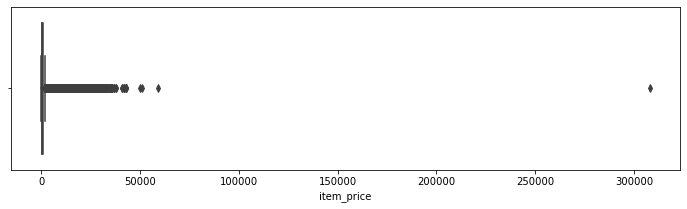

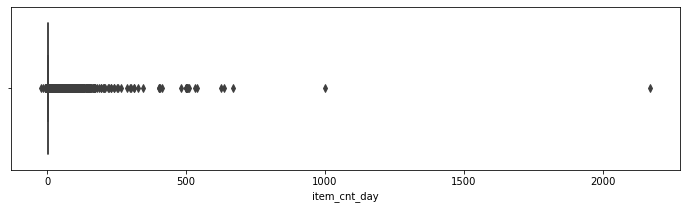

In [ ]:
plt.figure(figsize=(12,3))
sns.boxplot(x='item_price', data=sales)

plt.figure(figsize=(12,3))
sns.boxplot(x='item_cnt_day', data=sales)
plt.show()

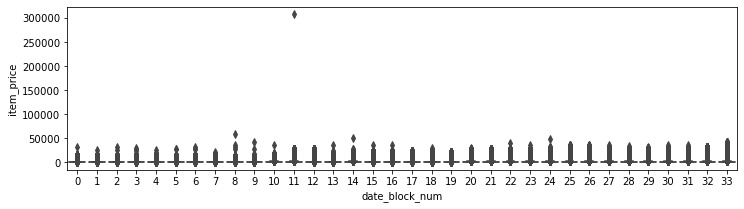

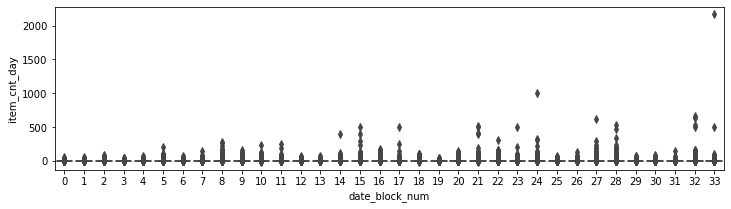

In [ ]:
plt.figure(figsize=(12,3))
sns.boxplot(x = 'date_block_num', y = 'item_price', data = sales)

plt.figure(figsize=(12,3))
sns.boxplot(x = 'date_block_num', y = 'item_cnt_day', data = sales)
plt.show()

In [ ]:
# 이상치 확인
#한 아이템이 500개 초과 팔렸을때
sales[sales.item_cnt_day > 500]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1573253,2014-04-22,15,27,8057,1200.000000,502.0
1708207,2014-06-28,17,25,20949,5.000000,501.0
2048518,2014-10-02,21,12,9242,1500.000000,512.0
2067669,2014-10-09,21,55,19437,899.000000,508.0
2326930,2015-01-15,24,12,20949,4.000000,1000.0
2608040,2015-04-14,27,12,3731,1904.548077,624.0
2626181,2015-05-19,28,12,11373,155.192950,539.0
2851073,2015-09-29,32,55,9249,1500.000000,533.0
2851091,2015-09-30,32,55,9249,1702.825746,637.0
2864235,2015-09-30,32,12,9248,1692.526158,669.0


In [ ]:
sales[sales.item_cnt_day >= 500].count()

date              14
date_block_num    14
shop_id           14
item_id           14
item_price        14
item_cnt_day      14
dtype: int64

In [ ]:
sales[sales.item_price >= 50000].count()

date              3
date_block_num    3
shop_id           3
item_id           3
item_price        3
item_cnt_day      3
dtype: int64

In [ ]:
# 뚜렷한 이상치를 우선 제거 
sales = sales[sales.item_cnt_day < 500]
sales = sales[sales.item_price < 50000]

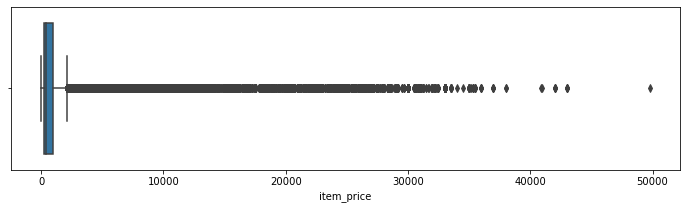

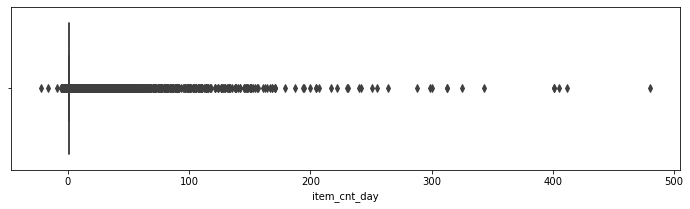

In [ ]:
# boxplot으로 이상치 재확인
plt.figure(figsize=(12,3))
sns.boxplot(x='item_price', data=sales);
plt.figure(figsize=(12,3))
sns.boxplot(x='item_cnt_day', data=sales)

plt.show()

### 음수값 처리
- item_price 컬럼과 item_cnt_day 컬럼의 음수값 처리하기

In [ ]:
# item_price 가 0 이하인 경우
(sales.item_price <= 0).sum()

1

In [ ]:
sales = sales[sales.item_price > 0] # 음수 값 처리

In [ ]:
# item_cnt_day 가 0 미만인 경우
(sales['item_cnt_day'] < 0).sum()

7356

- 판매된 제품의 개수가 음수(-) 인 경우 -> 환불된 제품의 개수로 추정
- 이전의 판매된 내역과 함께 제거하기! -> 환불모듈 적용

In [ ]:
# 환불모듈 적용
k = sales[sales.item_cnt_day < 0]
timefunc = time.time()

for i in range(len(k)):
    try:
        a = (sales[(sales.item_id == k.iloc[i,3]) & (sales.shop_id == k.iloc[i,2])])
        if a.date.min() < k.iloc[i,0]:
            h = a[(a.date==a.date[a.date < k.iloc[i,0]].max())].index[0]
            if sales.loc[h,'item_cnt_day'] > abs(k.iloc[i,5]):
                sales.loc[h,'item_cnt_day'] += k.iloc[i,5]
        else:
            pass
    except:
        pass
    
sales.drop(sales[sales.item_cnt_day < 0].index, axis = 0,inplace = True)

print(time.time() - timefunc)
sales.head(), sales.shape

115.4258246421814


(        date  date_block_num  shop_id  item_id  item_price  item_cnt_day
 0 2013-01-02               0       59    22154      999.00           1.0
 1 2013-01-03               0       25     2552      899.00           1.0
 3 2013-01-06               0       25     2554     1709.05           1.0
 4 2013-01-15               0       25     2555     1099.00           1.0
 5 2013-01-10               0       25     2564      349.00           1.0,
 (2928469, 6))

## 2) items data 
- item_id와 item_category_id가 숫자로 매핑되어있어 item_name 컬럼만 drop

In [ ]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [ ]:
# item_name 컬럼 drop 
items.drop(['item_name'], axis=1, inplace=True)
items.head()

,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40


## 3) item_categories data
- item_category_name을 라벨인코딩하여 type_id, sub_id 컬럼 생성
  - type_id: maincategory의 라벨인코딩 값
  - sub_id: subcategory의 라벨인코딩 값

In [ ]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [ ]:
type_encoder = LabelEncoder()

item_categories['split_name'] = item_categories['item_category_name'].str.split(' - ')
item_categories['type'] = item_categories['split_name'].map(lambda x: x[0].strip())
item_categories['type_id'] = type_encoder.fit_transform(item_categories['type'])

In [ ]:
subtype_encoder = LabelEncoder()

item_categories['sub'] = item_categories['split_name'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_categories['sub_id'] = subtype_encoder.fit_transform(item_categories['sub'])

In [ ]:
item_categories.head()

,item_category_name,item_category_id,split_name,type,type_id,sub,sub_id
0,PC - Гарнитуры/Наушники,0,"[PC, Гарнитуры/Наушники]",PC,0,Гарнитуры/Наушники,31
1,Аксессуары - PS2,1,"[Аксессуары, PS2]",Аксессуары,1,PS2,11
2,Аксессуары - PS3,2,"[Аксессуары, PS3]",Аксессуары,1,PS3,12
3,Аксессуары - PS4,3,"[Аксессуары, PS4]",Аксессуары,1,PS4,13
4,Аксессуары - PSP,4,"[Аксессуары, PSP]",Аксессуары,1,PSP,15


In [ ]:
item_categories['type'].value_counts()
# type으로 이상할만한 이름은 없다.

Книги                                13
Подарки                              12
Игровые консоли                       8
Игры                                  8
Аксессуары                            7
Музыка                                6
Программы                             6
Кино                                  5
Игры PC                               4
Карты оплаты                          4
Служебные                             2
Доставка товара                       1
PC                                    1
Чистые носители (штучные)             1
Игры MAC                              1
Билеты (Цифра)                        1
Элементы питания                      1
Карты оплаты (Кино, Музыка, Игры)     1
Чистые носители (шпиль)               1
Игры Android                          1
Name: type, dtype: int64

In [ ]:
item_categories = item_categories[['item_category_id','type_id','sub_id']]
item_categories.head()

,item_category_id,type_id,sub_id
0,0,0,31
1,1,1,11
2,2,1,12
3,3,1,13
4,4,1,15


## 4) shops data
- shop_name컬럼의 지역명을 라벨인코딩하여 city_id 컬럼 생성

In [ ]:
shops = pd.read_csv('shops.csv')
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [ ]:
# shop name 확인
shops['shop_name'].value_counts()

Мытищи ТРК "XL-3"                                  1
Воронеж ТРЦ "Максимир"                             1
Тюмень ТЦ "Гудвин"                                 1
Уфа ТК "Центральный"                               1
Москва ТК "Буденовский" (пав.К7)                   1
Новосибирск ТРЦ "Галерея Новосибирск"              1
РостовНаДону ТРК "Мегацентр Горизонт" Островной    1
Якутск ТЦ "Центральный"                            1
Воронеж ТРЦ Сити-Парк "Град"                       1
Красноярск ТЦ "Взлетка Плаза"                      1
Казань ТЦ "ПаркХаус" II                            1
РостовНаДону ТРК "Мегацентр Горизонт"              1
Курск ТЦ "Пушкинский"                              1
Москва ТЦ "Перловский"                             1
СПб ТК "Сенная"                                    1
Воронеж (Плехановская, 13)                         1
Уфа ТЦ "Семья" 2                                   1
Москва Магазин С21                                 1
Тюмень ТРЦ "Кристалл"                         

In [ ]:
# 도시명을 공백(' ')을 기준으로 분리하기 위해 수정
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'

In [ ]:
# 공백(' ')을 기준으로 분리
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.head()

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский


In [ ]:
# '!' 문자가 포함된 지명과 포함되지 않은 지명이 중복으로 표기됨. -> 통일시킴
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'

In [ ]:
shops['city'].value_counts()
# Интернет-магазин :온라인 상점?
# Выездная : 지명인지 모르겠음, 어디에도 지명이라고 안나옴
# 그래도 다른 city와 분리하기 위해 city_id로 만들어 두기로 함.

Москва              13
Якутск               4
РостовНаДону         3
Воронеж              3
Тюмень               3
Самара               2
Красноярск           2
Уфа                  2
Казань               2
Новосибирск          2
СПб                  2
Жуковский            2
Н.Новгород           2
Томск                1
Омск                 1
Курск                1
Чехов                1
СергиевПосад         1
Выездная             1
Калуга               1
Балашиха             1
Коломна              1
Сургут               1
Химки                1
Адыгея               1
Вологда              1
Цифровой             1
Волжский             1
Мытищи               1
Интернет-магазин     1
Ярославль            1
Name: city, dtype: int64

In [ ]:
city_encoder = LabelEncoder()

shops['city_id'] = city_encoder.fit_transform(shops['city'])
shops = shops[['shop_id', 'city_id']]
shops.head()

,shop_id,city_id
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


In [ ]:
shops.city_id.value_counts()

13    13
29     4
18     3
4      3
24     3
16     2
15     2
20     2
11     2
8      2
6      2
25     2
19     2
23     1
22     1
21     1
26     1
27     1
28     1
14     1
17     1
0      1
12     1
10     1
9      1
7      1
5      1
3      1
2      1
1      1
30     1
Name: city_id, dtype: int64

## 5) test data
- 예측달 34의 값이 채워진 date_block_num 컬럼 생성

In [ ]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [ ]:
test.shape

(214200, 3)

In [ ]:
len(test.shop_id.unique())
len(set(test.item_id) - set(sales.item_id))

363

- test 데이터에서 shop_id는 42개  
test 데이터에는 있지만 sales 데이터에는 없는 item_id가 총 363개
- 363개의 item_id에 대한 판매량은 0으로 예측

In [ ]:
# date_block_num 컬럼 생성
test['date_block_num'] = 34

In [ ]:
test.head()

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34
3,3,5,5232,34
4,4,5,5268,34


## 6) submission data

In [ ]:
submission = pd.read_csv('sample_submission.csv')
submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


## 7) 데이터프레임 merge 

### revenue (일 매출액) 컬럼 생성

In [ ]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
5,2013-01-10,0,25,2564,349.00,1.0


In [ ]:
# 총 수익
sales['revenue'] = sales['item_price'] * sales['item_cnt_day']
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
0,2013-01-02,0,59,22154,999.00,1.0,999.00
1,2013-01-03,0,25,2552,899.00,1.0,899.00
3,2013-01-06,0,25,2554,1709.05,1.0,1709.05
4,2013-01-15,0,25,2555,1099.00,1.0,1099.00
5,2013-01-10,0,25,2564,349.00,1.0,349.00


### matrix 데이터프레임 생성 및 컬럼추가
- 월별(date_block_num), 상점별(shop_id), 아이템별(item_id)의 matrix 데이터프레임 생성
- test 데이터와 matrix 데이터 결합

In [ ]:
ts = time.time() # 코드 시작 시간
matrix = []
cols = ['date_block_num', 'shop_id', 'item_id'] # 월별, 상점별, 아이템별

for i in range(34):
    sales_df = sales[sales.date_block_num == i]
    matrix.append(np.array(list(itertools.product([i], 
                    sales_df.shop_id.unique(), sales_df.item_id.unique())),
                    dtype='int16'))
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)

# int8 -> Byte (-128 to 127), int16 -> Integer (-32768 to 32767)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)

matrix.sort_values(cols, inplace=True)
time.time()-ts # 코드 실행 시간

# itertools.product : 중복 순열
# 월별, 상점별, 아이템별로 모든 가능한 조합을 나타낸다.
# vstack : 이 조합들을 월 순서대로 행 아래에 더해준다.

21.744810819625854

In [ ]:
matrix.head()

,date_block_num,shop_id,item_id
139168,0,0,19
141406,0,0,27
144881,0,0,28
142572,0,0,29
138861,0,0,32


In [ ]:
test.shape

(214200, 4)

- test데이터와 matrix데이터 결합

In [ ]:
matrix = pd.concat([matrix, test], ignore_index = True, sort=False, keys=cols)
matrix.fillna(-1, inplace = True)
matrix

,date_block_num,shop_id,item_id,ID
0,0,0,19,-1.0
1,0,0,27,-1.0
2,0,0,28,-1.0
3,0,0,29,-1.0
4,0,0,32,-1.0
...,...,...,...,...
11098655,34,45,18454,214195.0
11098656,34,45,16188,214196.0
11098657,34,45,15757,214197.0
11098658,34,45,19648,214198.0


In [ ]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11098660 entries, 0 to 11098659
Data columns (total 4 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date_block_num  int64  
 1   shop_id         int64  
 2   item_id         int64  
 3   ID              float64
dtypes: float64(1), int64(3)
memory usage: 338.7 MB


In [ ]:
matrix['ID'] = matrix['ID'].astype(np.int32)

In [ ]:
matrix.head()

,date_block_num,shop_id,item_id,ID
0,0,0,19,-1
1,0,0,27,-1
2,0,0,28,-1
3,0,0,29,-1
4,0,0,32,-1


In [ ]:
test.head()

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34
3,3,5,5232,34
4,4,5,5268,34


- city_id, item_category_id, type_id, sub_id 컬럼추가 (merge)

In [ ]:
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')  # ciry_id 추가
matrix= pd.merge(matrix, items, on=['item_id'], how='left')   # item_category 추가
matrix= pd.merge(matrix, item_categories, on=['item_category_id'], how='left') # type_id, sub_id 추가

matrix['city_id'] = matrix['city_id'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_id'] = matrix['type_id'].astype(np.int8)
matrix['sub_id'] = matrix['sub_id'].astype(np.int8)

In [ ]:
matrix.head()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id
0,0,0,19,-1,29,40,11,6
1,0,0,27,-1,29,19,5,12
2,0,0,28,-1,29,30,8,57
3,0,0,29,-1,29,23,5,18
4,0,0,32,-1,29,40,11,6


In [ ]:
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)

In [ ]:
matrix

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id
0,0,0,19,-1,29,40,11,6
1,0,0,27,-1,29,19,5,12
2,0,0,28,-1,29,30,8,57
3,0,0,29,-1,29,23,5,18
4,0,0,32,-1,29,40,11,6
...,...,...,...,...,...,...,...,...
11098655,34,45,18454,214195,20,55,13,4
11098656,34,45,16188,214196,20,64,14,44
11098657,34,45,15757,214197,20,55,13,4
11098658,34,45,19648,214198,20,40,11,6


- 월별 판매갯수(item_cnt_month)데이터 생성 및 matrix 데이터프레임에 merge
  - 월별, 상점별, 아이템별을 그룹화 하고, 일별 판매 개수('item_cnt_day') 합을 구함

In [ ]:
group = sales.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': ['sum']})
group.head()

item_cnt_day
                                        sum
date_block_num shop_id item_id             
0              0       32               6.0
                       33               3.0
                       35               1.0
                       43               1.0
                       51               2.0

In [ ]:
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)
group.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0


In [ ]:
# matrix 에 gorup데이터 merge 하여 컬럼을 붙임('item_cnt_month')
matrix = pd.merge(matrix, group, how='left')
matrix.head()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month
0,0,0,19,-1,29,40,11,6,NaN
1,0,0,27,-1,29,19,5,12,NaN
2,0,0,28,-1,29,30,8,57,NaN
3,0,0,29,-1,29,23,5,18,NaN
4,0,0,32,-1,29,40,11,6,6.0


- NaN 값은 판매 개수가 없다고 판단 -> 0으로 처리 및 임계값을 정해주기 위해 clip 사용

In [ ]:
print(matrix.item_cnt_month.max())
print(matrix.item_cnt_month.mean())
print(matrix.item_cnt_month.median())
print(len(matrix.item_cnt_month))

print((matrix.item_cnt_month > 30).sum())

# 30이 넘어가는 값은 6168개

1305.0
2.2667002855950766
1.0
11098660
6168


<AxesSubplot:xlabel='date_block_num', ylabel='item_cnt_month'>

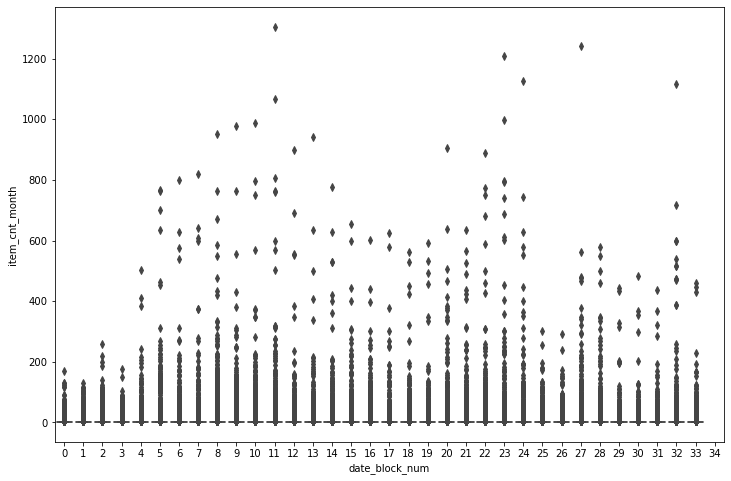

In [ ]:
plt.figure(figsize=(12,8))
sns.boxplot(x = 'date_block_num', y = 'item_cnt_month', data = matrix)

In [ ]:
# NaN 값은 판매 개수가 없다고 판단 -> 0으로 처리 및 임계값을 정해주기 위해 clip 사용
matrix['item_cnt_month'] = (matrix['item_cnt_month'].fillna(0).clip(0,30).astype(np.float16))
matrix.head()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month
0,0,0,19,-1,29,40,11,6,0.0
1,0,0,27,-1,29,19,5,12,0.0
2,0,0,28,-1,29,30,8,57,0.0
3,0,0,29,-1,29,23,5,18,0.0
4,0,0,32,-1,29,40,11,6,6.0


- shop_cnt_month (shop별 월 총 판매수량) 데이터 생성 및 matrix 데이터프레임에 merge

In [ ]:
group2 = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['sum']})
group2.columns = ['shop_cnt_month']
group2.reset_index(inplace=True)

In [ ]:
group2.head()

,date_block_num,shop_id,shop_cnt_month
0,0,0,5544.0
1,0,1,2942.0
2,0,2,1149.0
3,0,3,767.0
4,0,4,2114.0


In [ ]:
matrix = pd.merge(matrix, group2, on=['date_block_num', 'shop_id'], how='left')
matrix.head()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month,shop_cnt_month
0,0,0,19,-1,29,40,11,6,0.0,5544.0
1,0,0,27,-1,29,19,5,12,0.0,5544.0
2,0,0,28,-1,29,30,8,57,0.0,5544.0
3,0,0,29,-1,29,23,5,18,0.0,5544.0
4,0,0,32,-1,29,40,11,6,6.0,5544.0


In [ ]:
# matrix 원본 카피
matrix1 = matrix.copy()
matrix1.head()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month,shop_cnt_month
0,0,0,19,-1,29,40,11,6,0.0,5544.0
1,0,0,27,-1,29,19,5,12,0.0,5544.0
2,0,0,28,-1,29,30,8,57,0.0,5544.0
3,0,0,29,-1,29,23,5,18,0.0,5544.0
4,0,0,32,-1,29,40,11,6,6.0,5544.0


- categoty_cnt_month (categoty별 월 판매수량) 데이터 생성 및 matrix 데이터프레임에 merge

In [ ]:
group2 = matrix1.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['sum']})
group2.columns = ['category_cnt_month']
group2.reset_index(inplace=True)
matrix1 = pd.merge(matrix1, group2, on=['date_block_num', 'item_category_id'], how='left')
matrix1.head()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month,shop_cnt_month,category_cnt_month
0,0,0,19,-1,29,40,11,6,0.0,5544.0,32480.0
1,0,0,27,-1,29,19,5,12,0.0,5544.0,8992.0
2,0,0,28,-1,29,30,8,57,0.0,5544.0,21776.0
3,0,0,29,-1,29,23,5,18,0.0,5544.0,4172.0
4,0,0,32,-1,29,40,11,6,6.0,5544.0,32480.0


- city_cnt_month (city별 월 판매수량) 데이터 생성 및 matrix 데이터프레임에 merge

In [ ]:
group_1 = matrix1.groupby(['date_block_num', 'city_id']).agg({'item_cnt_month': ['sum']})
group_1.columns = ['city_cnt_month']
group_1.reset_index(inplace=True)
matrix1 = pd.merge(matrix1, group_1, on=['date_block_num', 'city_id'], how='left')
matrix1.head()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month,shop_cnt_month,category_cnt_month,city_cnt_month
0,0,0,19,-1,29,40,11,6,0.0,5544.0,32480.0,8488.0
1,0,0,27,-1,29,19,5,12,0.0,5544.0,8992.0,8488.0
2,0,0,28,-1,29,30,8,57,0.0,5544.0,21776.0,8488.0
3,0,0,29,-1,29,23,5,18,0.0,5544.0,4172.0,8488.0
4,0,0,32,-1,29,40,11,6,6.0,5544.0,32480.0,8488.0


- sub_cnt_month (subcategory별 월 판매수량) 데이터 생성 및 matrix 데이터프레임에 merge

In [ ]:
types = matrix1.groupby(['date_block_num', 'sub_id']).agg({'item_cnt_month' : 'sum'})
types.columns = ['sub_cnt_month']
types.reset_index(inplace=True)
matrix1 = pd.merge(matrix1, types, on = ['date_block_num', 'sub_id'], how = 'left')
matrix1.head()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month,shop_cnt_month,category_cnt_month,city_cnt_month,sub_cnt_month
0,0,0,19,-1,29,40,11,6,0.0,5544.0,32480.0,8488.0,32480.0
1,0,0,27,-1,29,19,5,12,0.0,5544.0,8992.0,8488.0,10768.0
2,0,0,28,-1,29,30,8,57,0.0,5544.0,21776.0,8488.0,21776.0
3,0,0,29,-1,29,23,5,18,0.0,5544.0,4172.0,8488.0,5320.0
4,0,0,32,-1,29,40,11,6,6.0,5544.0,32480.0,8488.0,32480.0


- item_price(item별 평균 가격) 데이터 생성 및 matrix 데이터프레임에 merge

In [ ]:
group_2 = sales.groupby(['item_id']).agg({'item_price': ['mean']})
group_2.columns = ['item_price'] # item_price_by_item_id
group_2.reset_index(inplace=True)
matrix1 = pd.merge(matrix1, group_2, on = ['item_id'], how = 'left')
matrix1.head()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month,shop_cnt_month,category_cnt_month,city_cnt_month,sub_cnt_month,item_price
0,0,0,19,-1,29,40,11,6,0.0,5544.0,32480.0,8488.0,32480.0,28.000000
1,0,0,27,-1,29,19,5,12,0.0,5544.0,8992.0,8488.0,10768.0,1461.228571
2,0,0,28,-1,29,30,8,57,0.0,5544.0,21776.0,8488.0,21776.0,308.975294
3,0,0,29,-1,29,23,5,18,0.0,5544.0,4172.0,8488.0,5320.0,1702.384615
4,0,0,32,-1,29,40,11,6,6.0,5544.0,32480.0,8488.0,32480.0,249.736179


In [ ]:
# item_price NaN값 처리하기
matrix1['item_price'].fillna(0, inplace=True)

In [ ]:
matrix2 = matrix1.copy()

- item_shop_cnt_month(shop,item별 판매량) 데이터 생성 및 matrix 데이터프레임에 merge

In [ ]:
matrix2['season'] = np.where(matrix2['date_block_num'].isin([2,3,4,14,15,16,26,27,28]), 0,
                            np.where(matrix2['date_block_num'].isin([5,6,7,17,18,19,29,30,31]), 1,
                                    np.where(matrix2['date_block_num'].isin([8,9,10,20,21,22,32,33]), 2,3)))
matrix2.tail()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month,shop_cnt_month,category_cnt_month,city_cnt_month,sub_cnt_month,item_price,season
11098655,34,45,18454,214195,20,55,13,4,0.0,0.0,0.0,0.0,0.0,188.681084,3
11098656,34,45,16188,214196,20,64,14,44,0.0,0.0,0.0,0.0,0.0,1256.975000,3
11098657,34,45,15757,214197,20,55,13,4,0.0,0.0,0.0,0.0,0.0,198.110811,3
11098658,34,45,19648,214198,20,40,11,6,0.0,0.0,0.0,0.0,0.0,98.096296,3
11098659,34,45,969,214199,20,37,11,1,0.0,0.0,0.0,0.0,0.0,502.297061,3


- season_avg_item_cnt (계절별 평균 판매 수량)

In [ ]:
group = matrix2.groupby(['date_block_num', 'season']).agg({'item_cnt_month': ['mean']})
group.columns = ['season_avg_item_cnt']
group.reset_index(inplace=True)

matrix2 = pd.merge(matrix2, group, on=['date_block_num', 'season'], how='left')
matrix2['season_avg_item_cnt'] = matrix2['season_avg_item_cnt'].astype(np.float16)
matrix2.tail()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month,shop_cnt_month,category_cnt_month,city_cnt_month,sub_cnt_month,item_price,season,season_avg_item_cnt
11098655,34,45,18454,214195,20,55,13,4,0.0,0.0,0.0,0.0,0.0,188.681084,3,0.0
11098656,34,45,16188,214196,20,64,14,44,0.0,0.0,0.0,0.0,0.0,1256.975000,3,0.0
11098657,34,45,15757,214197,20,55,13,4,0.0,0.0,0.0,0.0,0.0,198.110811,3,0.0
11098658,34,45,19648,214198,20,40,11,6,0.0,0.0,0.0,0.0,0.0,98.096296,3,0.0
11098659,34,45,969,214199,20,37,11,1,0.0,0.0,0.0,0.0,0.0,502.297061,3,0.0


- season_shop_avg_cnt (계절별 shop별 평균 판매량)

In [ ]:
group = matrix2.groupby(['date_block_num', 'shop_id', 'season']).agg({'item_cnt_month': ['mean']})
group.columns = ['season_shop_avg_cnt']
group.reset_index(inplace=True)

matrix2 = pd.merge(matrix2, group, on=['date_block_num', 'shop_id', 'season'], how='left')
matrix2['season_shop_avg_cnt'] = matrix2['season_shop_avg_cnt'].astype(np.float16)
matrix2.head()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month,shop_cnt_month,category_cnt_month,city_cnt_month,sub_cnt_month,item_price,season,season_avg_item_cnt,season_shop_avg_cnt
0,0,0,19,-1,29,40,11,6,0.0,5544.0,32480.0,8488.0,32480.0,28.000000,3,0.35498,0.683594
1,0,0,27,-1,29,19,5,12,0.0,5544.0,8992.0,8488.0,10768.0,1461.228571,3,0.35498,0.683594
2,0,0,28,-1,29,30,8,57,0.0,5544.0,21776.0,8488.0,21776.0,308.975294,3,0.35498,0.683594
3,0,0,29,-1,29,23,5,18,0.0,5544.0,4172.0,8488.0,5320.0,1702.384615,3,0.35498,0.683594
4,0,0,32,-1,29,40,11,6,6.0,5544.0,32480.0,8488.0,32480.0,249.736179,3,0.35498,0.683594


- season_city_avg_cnt (계절별 city별 평균 판매량)

In [ ]:
group = matrix2.groupby(['date_block_num', 'city_id', 'season']).agg({'item_cnt_month': ['mean']})
group.columns = ['season_city_avg_cnt']
group.reset_index(inplace=True)

matrix2 = pd.merge(matrix2, group, on=['date_block_num', 'city_id', 'season'], how='left')
matrix2['season_city_avg_cnt'] = matrix2['season_city_avg_cnt'].astype(np.float16)
matrix2.head()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month,shop_cnt_month,category_cnt_month,city_cnt_month,sub_cnt_month,item_price,season,season_avg_item_cnt,season_shop_avg_cnt,season_city_avg_cnt
0,0,0,19,-1,29,40,11,6,0.0,5544.0,32480.0,8488.0,32480.0,28.000000,3,0.35498,0.683594,0.523438
1,0,0,27,-1,29,19,5,12,0.0,5544.0,8992.0,8488.0,10768.0,1461.228571,3,0.35498,0.683594,0.523438
2,0,0,28,-1,29,30,8,57,0.0,5544.0,21776.0,8488.0,21776.0,308.975294,3,0.35498,0.683594,0.523438
3,0,0,29,-1,29,23,5,18,0.0,5544.0,4172.0,8488.0,5320.0,1702.384615,3,0.35498,0.683594,0.523438
4,0,0,32,-1,29,40,11,6,6.0,5544.0,32480.0,8488.0,32480.0,249.736179,3,0.35498,0.683594,0.523438


- season_sub_avg_cnt (계절별 sub-category별 평균 판매량)

In [ ]:
group = matrix2.groupby(['date_block_num', 'sub_id', 'season']).agg({'item_cnt_month': ['mean']})
group.columns = ['season_sub_avg_cnt']
group.reset_index(inplace=True)

matrix2 = pd.merge(matrix2, group, on=['date_block_num', 'sub_id', 'season'], how='left')
matrix2['season_sub_avg_cnt'] = matrix2['season_sub_avg_cnt'].astype(np.float16)
matrix2.head()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month,shop_cnt_month,category_cnt_month,city_cnt_month,sub_cnt_month,item_price,season,season_avg_item_cnt,season_shop_avg_cnt,season_city_avg_cnt,season_sub_avg_cnt
0,0,0,19,-1,29,40,11,6,0.0,5544.0,32480.0,8488.0,32480.0,28.000000,3,0.35498,0.683594,0.523438,0.301514
1,0,0,27,-1,29,19,5,12,0.0,5544.0,8992.0,8488.0,10768.0,1461.228571,3,0.35498,0.683594,0.523438,0.830566
2,0,0,28,-1,29,30,8,57,0.0,5544.0,21776.0,8488.0,21776.0,308.975294,3,0.35498,0.683594,0.523438,1.166016
3,0,0,29,-1,29,23,5,18,0.0,5544.0,4172.0,8488.0,5320.0,1702.384615,3,0.35498,0.683594,0.523438,0.582031
4,0,0,32,-1,29,40,11,6,6.0,5544.0,32480.0,8488.0,32480.0,249.736179,3,0.35498,0.683594,0.523438,0.301514


In [ ]:
# matrix2 데이터 copy
matrix3 = matrix2.copy()

## 8) Matrix에 new features & lags 추가

In [ ]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [ ]:
matrix3 = lag_feature(matrix3, [1,3,6,12], 'item_cnt_month')
matrix3

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month,shop_cnt_month,...,item_price,season,season_avg_item_cnt,season_shop_avg_cnt,season_city_avg_cnt,season_sub_avg_cnt,item_cnt_month_lag_1,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,0,19,-1,29,40,11,6,0.0,5544.0,...,28.000000,3,0.35498,0.683594,0.523438,0.301514,NaN,NaN,NaN,NaN
1,0,0,27,-1,29,19,5,12,0.0,5544.0,...,1461.228571,3,0.35498,0.683594,0.523438,0.830566,NaN,NaN,NaN,NaN
2,0,0,28,-1,29,30,8,57,0.0,5544.0,...,308.975294,3,0.35498,0.683594,0.523438,1.166016,NaN,NaN,NaN,NaN
3,0,0,29,-1,29,23,5,18,0.0,5544.0,...,1702.384615,3,0.35498,0.683594,0.523438,0.582031,NaN,NaN,NaN,NaN
4,0,0,32,-1,29,40,11,6,6.0,5544.0,...,249.736179,3,0.35498,0.683594,0.523438,0.301514,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11098655,34,45,18454,214195,20,55,13,4,0.0,0.0,...,188.681084,3,0.00000,0.000000,0.000000,0.000000,1.0,0.0,0.0,NaN
11098656,34,45,16188,214196,20,64,14,44,0.0,0.0,...,1256.975000,3,0.00000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN
11098657,34,45,15757,214197,20,55,13,4,0.0,0.0,...,198.110811,3,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
11098658,34,45,19648,214198,20,40,11,6,0.0,0.0,...,98.096296,3,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,NaN


- date_avg_item_cnt(월 평균 판매수량) 컬럼 생성 및 lag[1,3,6,12] -> matrix에 추가

In [ ]:
group = matrix3.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_avg_item_cnt']
group.reset_index(inplace=True)
matrix3 = pd.merge(matrix3, group, on=['date_block_num'], how='left')
matrix3['date_avg_item_cnt'] = matrix3['date_avg_item_cnt'].astype(np.float16)
matrix3 = lag_feature(matrix3, [1,3,6,12], 'date_avg_item_cnt')
matrix3.head()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month,shop_cnt_month,...,season_sub_avg_cnt,item_cnt_month_lag_1,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt,date_avg_item_cnt_lag_1,date_avg_item_cnt_lag_3,date_avg_item_cnt_lag_6,date_avg_item_cnt_lag_12
0,0,0,19,-1,29,40,11,6,0.0,5544.0,...,0.301514,NaN,NaN,NaN,NaN,0.35498,NaN,NaN,NaN,NaN
1,0,0,27,-1,29,19,5,12,0.0,5544.0,...,0.830566,NaN,NaN,NaN,NaN,0.35498,NaN,NaN,NaN,NaN
2,0,0,28,-1,29,30,8,57,0.0,5544.0,...,1.166016,NaN,NaN,NaN,NaN,0.35498,NaN,NaN,NaN,NaN
3,0,0,29,-1,29,23,5,18,0.0,5544.0,...,0.582031,NaN,NaN,NaN,NaN,0.35498,NaN,NaN,NaN,NaN
4,0,0,32,-1,29,40,11,6,6.0,5544.0,...,0.301514,NaN,NaN,NaN,NaN,0.35498,NaN,NaN,NaN,NaN


- date_item_avg_item_cnt(월별 item별 item  평균 판매량) 컬럼 생성

In [ ]:
group = matrix3.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_item_avg_item_cnt']
group.reset_index(inplace=True)

matrix3 = pd.merge(matrix3, group, on=['date_block_num', 'item_id'], how='left')
matrix3['date_item_avg_item_cnt'] = matrix3['date_item_avg_item_cnt'].astype(np.float16)
matrix3.head()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month,shop_cnt_month,...,item_cnt_month_lag_1,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt,date_avg_item_cnt_lag_1,date_avg_item_cnt_lag_3,date_avg_item_cnt_lag_6,date_avg_item_cnt_lag_12,date_item_avg_item_cnt
0,0,0,19,-1,29,40,11,6,0.0,5544.0,...,NaN,NaN,NaN,NaN,0.35498,NaN,NaN,NaN,NaN,0.022217
1,0,0,27,-1,29,19,5,12,0.0,5544.0,...,NaN,NaN,NaN,NaN,0.35498,NaN,NaN,NaN,NaN,0.155518
2,0,0,28,-1,29,30,8,57,0.0,5544.0,...,NaN,NaN,NaN,NaN,0.35498,NaN,NaN,NaN,NaN,0.177734
3,0,0,29,-1,29,23,5,18,0.0,5544.0,...,NaN,NaN,NaN,NaN,0.35498,NaN,NaN,NaN,NaN,0.111084
4,0,0,32,-1,29,40,11,6,6.0,5544.0,...,NaN,NaN,NaN,NaN,0.35498,NaN,NaN,NaN,NaN,6.089844


- date_shop_avg_item_cnt(월별 shop별 평균 판매수량) 컬럼 생성 및 lag[1,3,6,12] -> matrix에 추가

In [ ]:
group = matrix3.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix3 = pd.merge(matrix3, group, on=['date_block_num','shop_id'], how='left')
matrix3['date_shop_avg_item_cnt'] = matrix3['date_shop_avg_item_cnt'].astype(np.float16)

matrix3 = lag_feature(matrix3, [1,3,6,12], 'date_shop_avg_item_cnt')
matrix3.head()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month,shop_cnt_month,...,date_avg_item_cnt_lag_1,date_avg_item_cnt_lag_3,date_avg_item_cnt_lag_6,date_avg_item_cnt_lag_12,date_item_avg_item_cnt,date_shop_avg_item_cnt,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12
0,0,0,19,-1,29,40,11,6,0.0,5544.0,...,NaN,NaN,NaN,NaN,0.022217,0.683594,NaN,NaN,NaN,NaN
1,0,0,27,-1,29,19,5,12,0.0,5544.0,...,NaN,NaN,NaN,NaN,0.155518,0.683594,NaN,NaN,NaN,NaN
2,0,0,28,-1,29,30,8,57,0.0,5544.0,...,NaN,NaN,NaN,NaN,0.177734,0.683594,NaN,NaN,NaN,NaN
3,0,0,29,-1,29,23,5,18,0.0,5544.0,...,NaN,NaN,NaN,NaN,0.111084,0.683594,NaN,NaN,NaN,NaN
4,0,0,32,-1,29,40,11,6,6.0,5544.0,...,NaN,NaN,NaN,NaN,6.089844,0.683594,NaN,NaN,NaN,NaN


- date_cat_avg_item_cnt(월별 category별 item 평균 판매량) 컬럼 생성

In [ ]:
group = matrix3.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix3 = pd.merge(matrix3, group, on=['date_block_num', 'item_category_id'], how='left')
matrix3['date_cat_avg_item_cnt'] = matrix3['date_cat_avg_item_cnt'].astype(np.float16)
matrix3.head()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month,shop_cnt_month,...,date_avg_item_cnt_lag_3,date_avg_item_cnt_lag_6,date_avg_item_cnt_lag_12,date_item_avg_item_cnt,date_shop_avg_item_cnt,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt
0,0,0,19,-1,29,40,11,6,0.0,5544.0,...,NaN,NaN,NaN,0.022217,0.683594,NaN,NaN,NaN,NaN,0.301514
1,0,0,27,-1,29,19,5,12,0.0,5544.0,...,NaN,NaN,NaN,0.155518,0.683594,NaN,NaN,NaN,NaN,0.850586
2,0,0,28,-1,29,30,8,57,0.0,5544.0,...,NaN,NaN,NaN,0.177734,0.683594,NaN,NaN,NaN,NaN,1.166016
3,0,0,29,-1,29,23,5,18,0.0,5544.0,...,NaN,NaN,NaN,0.111084,0.683594,NaN,NaN,NaN,NaN,0.551758
4,0,0,32,-1,29,40,11,6,6.0,5544.0,...,NaN,NaN,NaN,6.089844,0.683594,NaN,NaN,NaN,NaN,0.301514


- date_shop_cat_avg_item_cnt(월별 shop별 item 평균 판매량) 컬럼 생성

In [ ]:
group = matrix3.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix3 = pd.merge(matrix3, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix3['date_shop_cat_avg_item_cnt'] = matrix3['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix3.head()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month,shop_cnt_month,...,date_avg_item_cnt_lag_6,date_avg_item_cnt_lag_12,date_item_avg_item_cnt,date_shop_avg_item_cnt,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt,date_shop_cat_avg_item_cnt
0,0,0,19,-1,29,40,11,6,0.0,5544.0,...,NaN,NaN,0.022217,0.683594,NaN,NaN,NaN,NaN,0.301514,0.762695
1,0,0,27,-1,29,19,5,12,0.0,5544.0,...,NaN,NaN,0.155518,0.683594,NaN,NaN,NaN,NaN,0.850586,1.467773
2,0,0,28,-1,29,30,8,57,0.0,5544.0,...,NaN,NaN,0.177734,0.683594,NaN,NaN,NaN,NaN,1.166016,1.821289
3,0,0,29,-1,29,23,5,18,0.0,5544.0,...,NaN,NaN,0.111084,0.683594,NaN,NaN,NaN,NaN,0.551758,1.541992
4,0,0,32,-1,29,40,11,6,6.0,5544.0,...,NaN,NaN,6.089844,0.683594,NaN,NaN,NaN,NaN,0.301514,0.762695


- date_city_avg_item_cnt(월별 city별 item 평균 판매량) 컬럼 생성

In [ ]:
group = matrix3.groupby(['date_block_num', 'city_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix3 = pd.merge(matrix3, group, on=['date_block_num', 'city_id'], how='left')
matrix3['date_city_avg_item_cnt'] = matrix3['date_city_avg_item_cnt'].astype(np.float16)
matrix3.head()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month,shop_cnt_month,...,date_avg_item_cnt_lag_12,date_item_avg_item_cnt,date_shop_avg_item_cnt,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt,date_shop_cat_avg_item_cnt,date_city_avg_item_cnt
0,0,0,19,-1,29,40,11,6,0.0,5544.0,...,NaN,0.022217,0.683594,NaN,NaN,NaN,NaN,0.301514,0.762695,0.523438
1,0,0,27,-1,29,19,5,12,0.0,5544.0,...,NaN,0.155518,0.683594,NaN,NaN,NaN,NaN,0.850586,1.467773,0.523438
2,0,0,28,-1,29,30,8,57,0.0,5544.0,...,NaN,0.177734,0.683594,NaN,NaN,NaN,NaN,1.166016,1.821289,0.523438
3,0,0,29,-1,29,23,5,18,0.0,5544.0,...,NaN,0.111084,0.683594,NaN,NaN,NaN,NaN,0.551758,1.541992,0.523438
4,0,0,32,-1,29,40,11,6,6.0,5544.0,...,NaN,6.089844,0.683594,NaN,NaN,NaN,NaN,0.301514,0.762695,0.523438


- date_item_city_avg_item_cnt(월별 itme/city별 item 평균 판매량) 컬럼 생성

In [ ]:
group = matrix3.groupby(['date_block_num', 'item_id', 'city_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix3 = pd.merge(matrix3, group, on=['date_block_num', 'item_id', 'city_id'], how='left')
matrix3['date_item_city_avg_item_cnt'] = matrix3['date_item_city_avg_item_cnt'].astype(np.float16)
matrix3 = lag_feature(matrix3, [1], 'date_item_city_avg_item_cnt')
matrix3.head()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month,shop_cnt_month,...,date_shop_avg_item_cnt,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt,date_shop_cat_avg_item_cnt,date_city_avg_item_cnt,date_item_city_avg_item_cnt,date_item_city_avg_item_cnt_lag_1
0,0,0,19,-1,29,40,11,6,0.0,5544.0,...,0.683594,NaN,NaN,NaN,NaN,0.301514,0.762695,0.523438,0.0,NaN
1,0,0,27,-1,29,19,5,12,0.0,5544.0,...,0.683594,NaN,NaN,NaN,NaN,0.850586,1.467773,0.523438,0.5,NaN
2,0,0,28,-1,29,30,8,57,0.0,5544.0,...,0.683594,NaN,NaN,NaN,NaN,1.166016,1.821289,0.523438,0.0,NaN
3,0,0,29,-1,29,23,5,18,0.0,5544.0,...,0.683594,NaN,NaN,NaN,NaN,0.551758,1.541992,0.523438,0.5,NaN
4,0,0,32,-1,29,40,11,6,6.0,5544.0,...,0.683594,NaN,NaN,NaN,NaN,0.301514,0.762695,0.523438,6.5,NaN


In [ ]:
# lag를 12까지 사용했으므로 첫 12달은 drop
matrix3 = matrix3[matrix3.date_block_num > 11]

In [ ]:
matrix_nan1 = matrix3.copy() # ffill을 이용한 NaN값 처리시 사용
matrix_nan2 = matrix3.copy() # IterativeImputer을 이용한 NaN값 처리시 사용

## 9) NaN값 처리

### 1) Random Forest를 이용한 일부 NaN값 예측
- date_avg_item_cnt_lag_1,3,6,12 값 RandomForest를 이용하여 NaN값 대체

In [ ]:
def predict_lag(data):
    
    # NaN값인 것과 아닌 것을 나누어 줌
    lag0 = data.loc[data['date_avg_item_cnt_lag_1'].isnull()]  # NaN
    lag1 = data.loc[~data['date_avg_item_cnt_lag_1'].isnull()]  

    # 예측할 피쳐 선택
    wCol = ['date_block_num', 'shop_id', 'item_id', 'ID', 'city_id',
       'item_category_id', 'type_id', 'sub_id', 'item_cnt_month',
       'shop_cnt_month', 'category_cnt_month', 'city_cnt_month',
       'sub_cnt_month', 'item_price', 'season', 'season_avg_item_cnt',
       'season_shop_avg_cnt', 'season_city_avg_cnt', 'season_sub_avg_cnt',
        'date_avg_item_cnt', 'date_item_avg_item_cnt',
       'date_shop_avg_item_cnt', 'date_cat_avg_item_cnt',
       'date_shop_cat_avg_item_cnt', 'date_city_avg_item_cnt',
       'date_item_city_avg_item_cnt']

    # NaN이 아닌 데이터들의 타입을 스트링으로 바꾸어줌
    lag1['date_avg_item_cnt_lag_1'] = lag1['date_avg_item_cnt_lag_1'].astype('str')

    # 랜덤포레스트 분류기 사용
    rfModel_lag = RandomForestClassifier()
 
    # wCol에 있는 피쳐의 값을 바탕으로 학습
    rfModel_lag.fit(lag1[wCol], lag1['date_avg_item_cnt_lag_1'])

    # 학습한 값을 바탕으로 NaN으로 기록된 데이터 값 예측
    lag0Values = rfModel_lag.predict(X = lag0[wCol])

    # 값을 다 예측 후 비교해보기 위해 예측한 값을 넣어 줄 데이터프레임 새로 만들기
    predictlag0 = lag0
    predictlag1 = lag1

    # 값이 NaN으로 기록된 값에 대해 예측한 값을 넣어줌
    predictlag0['date_avg_item_cnt_lag_1'] = lag0Values

    # NaN이 아닌 데이터프레임에 예측한 값이 있는 데이터프레임을 합쳐줌
    data = predictlag1.append(predictlag0)
    
    # 데이터타입을 float으로 지정해 준다.
    data['date_avg_item_cnt_lag_1'] = data['date_avg_item_cnt_lag_1'].astype("float")

    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)

    return data

In [ ]:
matrix3 = predict_lag(matrix3)
matrix3

In [ ]:
def predict_lag(data):
    
    lag0 = data.loc[data['date_avg_item_cnt_lag_3'].isnull()]
    lag1 = data.loc[~data['date_avg_item_cnt_lag_3'].isnull()]

    wCol = ['date_block_num', 'shop_id', 'item_id', 'ID', 'city_id',
       'item_category_id', 'type_id', 'sub_id', 'item_cnt_month',
       'shop_cnt_month', 'category_cnt_month', 'city_cnt_month',
       'sub_cnt_month', 'item_price', 'season', 'season_avg_item_cnt',
       'season_shop_avg_cnt', 'season_city_avg_cnt', 'season_sub_avg_cnt',
        'date_avg_item_cnt', 'date_item_avg_item_cnt',
       'date_shop_avg_item_cnt', 'date_cat_avg_item_cnt',
       'date_shop_cat_avg_item_cnt', 'date_city_avg_item_cnt',
       'date_item_city_avg_item_cnt']

    lag1['date_avg_item_cnt_lag_3'] = lag1['date_avg_item_cnt_lag_3'].astype('str')

    rfModel_lag = RandomForestClassifier()
    
    rfModel_lag.fit(lag1[wCol], lag1['date_avg_item_cnt_lag_3'])

    lag0Values = rfModel_lag.predict(X = lag0[wCol])

    predictlag0 = lag0
    predictlag1 = lag1

    predictlag0['date_avg_item_cnt_lag_3'] = lag0Values

    data = predictlag1.append(predictlag0)
    data['date_avg_item_cnt_lag_3'] = data['date_avg_item_cnt_lag_3'].astype("float")

    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)

    return data

In [ ]:
matrix3 = predict_lag(matrix3)
matrix3

In [ ]:
def predict_lag(data):
    
    lag0 = data.loc[data['date_avg_item_cnt_lag_6'].isnull()]
    lag1 = data.loc[~data['date_avg_item_cnt_lag_6'].isnull()]

    wCol = ['date_block_num', 'shop_id', 'item_id', 'ID', 'city_id',
       'item_category_id', 'type_id', 'sub_id', 'item_cnt_month',
       'shop_cnt_month', 'category_cnt_month', 'city_cnt_month',
       'sub_cnt_month', 'item_price', 'season', 'season_avg_item_cnt',
       'season_shop_avg_cnt', 'season_city_avg_cnt', 'season_sub_avg_cnt',
        'date_avg_item_cnt', 'date_item_avg_item_cnt',
       'date_shop_avg_item_cnt', 'date_cat_avg_item_cnt',
       'date_shop_cat_avg_item_cnt', 'date_city_avg_item_cnt',
       'date_item_city_avg_item_cnt']

    lag1['date_avg_item_cnt_lag_6'] = lag1['date_avg_item_cnt_lag_6'].astype('str')

    rfModel_lag = RandomForestClassifier()
    
    rfModel_lag.fit(lag1[wCol], lag1['date_avg_item_cnt_lag_6'])

    lag0Values = rfModel_lag.predict(X = lag0[wCol])

    predictlag0 = lag0
    predictlag1 = lag1

    predictlag0['date_avg_item_cnt_lag_6'] = lag0Values

    data = predictlag1.append(predictlag0)
    data['date_avg_item_cnt_lag_6'] = data['date_avg_item_cnt_lag_6'].astype("float")

    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)

    return data

In [ ]:
matrix3 = predict_lag(matrix3)
matrix3

In [ ]:
def predict_lag(data):
    
    lag0 = data.loc[data['date_avg_item_cnt_lag_12'].isnull()]
    lag1 = data.loc[~data['date_avg_item_cnt_lag_12'].isnull()]

    wCol = ['date_block_num', 'shop_id', 'item_id', 'ID', 'city_id',
       'item_category_id', 'type_id', 'sub_id', 'item_cnt_month',
       'shop_cnt_month', 'category_cnt_month', 'city_cnt_month',
       'sub_cnt_month', 'item_price', 'season', 'season_avg_item_cnt',
       'season_shop_avg_cnt', 'season_city_avg_cnt', 'season_sub_avg_cnt',
        'date_avg_item_cnt', 'date_item_avg_item_cnt',
       'date_shop_avg_item_cnt', 'date_cat_avg_item_cnt',
       'date_shop_cat_avg_item_cnt', 'date_city_avg_item_cnt',
       'date_item_city_avg_item_cnt']

    lag1['date_avg_item_cnt_lag_12'] = lag1['date_avg_item_cnt_lag_12'].astype('str')

    rfModel_lag = RandomForestClassifier()
    
    rfModel_lag.fit(lag1[wCol], lag1['date_avg_item_cnt_lag_12'])

    lag0Values = rfModel_lag.predict(X = lag0[wCol])

    predictlag0 = lag0
    predictlag1 = lag1

    predictlag0['date_avg_item_cnt_lag_12'] = lag0Values

    data = predictlag1.append(predictlag0)
    data['date_avg_item_cnt_lag_12'] = data['date_avg_item_cnt_lag_12'].astype("float")

    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)

    return data

In [ ]:
matrix3 = predict_lag(matrix3)
matrix3

### 2) 나머지 NaN값 0으로 처리

In [ ]:
# matrix3 의 나머지 NaN값 처리 (lag로 인한 NAN)
matrix3.fillna(0, inplace = True)
matrix3.isnull().sum()

date_block_num                       0
shop_id                              0
item_id                              0
ID                                   0
city_id                              0
item_category_id                     0
type_id                              0
sub_id                               0
item_cnt_month                       0
shop_cnt_month                       0
category_cnt_month                   0
city_cnt_month                       0
sub_cnt_month                        0
item_price                           0
season                               0
season_avg_item_cnt                  0
season_shop_avg_cnt                  0
season_city_avg_cnt                  0
season_sub_avg_cnt                   0
item_cnt_month_lag_1                 0
item_cnt_month_lag_3                 0
item_cnt_month_lag_6                 0
item_cnt_month_lag_12                0
date_avg_item_cnt                    0
date_avg_item_cnt_lag_1              0
date_avg_item_cnt_lag_3  

### 3) ffill을 이용한 NaN값 처리
- 이후 모델 성능이 좋지 않아 시도만 해보았습니다.

In [ ]:
matrix_nan1.ffill(axis = 1)
# matrix3 = matrix_nan1.copy() # 해당 처리 방법 사용 시 실행

### 4) Iterative Imputer를 이용한 NaN값 예측

*   일부 모델링에 사용해보았습니다.



In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [ ]:
num_columns = ['item_price', 'item_cnt_month_lag_1', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12','date_avg_item_cnt_lag_1',
       'date_avg_item_cnt_lag_3', 'date_avg_item_cnt_lag_6',
       'date_avg_item_cnt_lag_12','date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_6',
       'date_shop_avg_item_cnt_lag_12','date_item_city_avg_item_cnt_lag_1']

In [ ]:
imp_mean = IterativeImputer(random_state=0)
matrix_nan2[num_columns] = imp_mean.fit_transform(impute_df[num_columns])
# matrix3 = matrix_nan2.copy() # 해당 처리 방법 사용 시 실행

- month(월) 컬럼 추가

In [ ]:
matrix3['month'] = matrix3['date_block_num'] % 12
matrix3

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,sub_id,item_cnt_month,shop_cnt_month,...,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt,date_shop_cat_avg_item_cnt,date_city_avg_item_cnt,date_item_city_avg_item_cnt,date_item_city_avg_item_cnt_lag_1,month
4478844,12,2,27,-1,0,19,5,12,0.0,883.0,...,0.151489,0.095398,0.096130,0.141724,0.752930,0.793945,0.117004,0.0,0.0,0
4478845,12,2,30,-1,0,40,11,6,0.0,883.0,...,0.151489,0.095398,0.096130,0.000000,0.261230,0.041809,0.117004,0.0,0.0,0
4478846,12,2,31,-1,0,37,11,1,0.0,883.0,...,0.151489,0.095398,0.096130,0.000000,0.194824,0.052246,0.117004,0.0,0.0,0
4478847,12,2,32,-1,0,40,11,6,1.0,883.0,...,0.151489,0.095398,0.096130,0.141724,0.261230,0.041809,0.117004,1.0,0.0,0
4478848,12,2,33,-1,0,37,11,1,1.0,883.0,...,0.151489,0.095398,0.096130,0.141724,0.194824,0.052246,0.117004,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11098655,34,45,18454,214195,20,55,13,4,0.0,0.0,...,0.129761,0.139282,0.142334,0.000000,0.000000,0.000000,0.000000,0.0,0.5,10
11098656,34,45,16188,214196,20,64,14,44,0.0,0.0,...,0.129761,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,10
11098657,34,45,15757,214197,20,55,13,4,0.0,0.0,...,0.129761,0.139282,0.142334,0.185913,0.000000,0.000000,0.000000,0.0,0.0,10
11098658,34,45,19648,214198,20,40,11,6,0.0,0.0,...,0.129761,0.139282,0.142334,0.000000,0.000000,0.000000,0.000000,0.0,0.0,10


In [ ]:
matrix3.shape  # matrix3 형태 확인

(6619816, 40)

In [ ]:
# matrix3 데이터 copy
matrix4 = matrix3.copy()

- matrix4 file -> data1.pkl 파일로 저장

In [ ]:
matrix4.to_pickle('data1.pkl')

## CODEBOOK

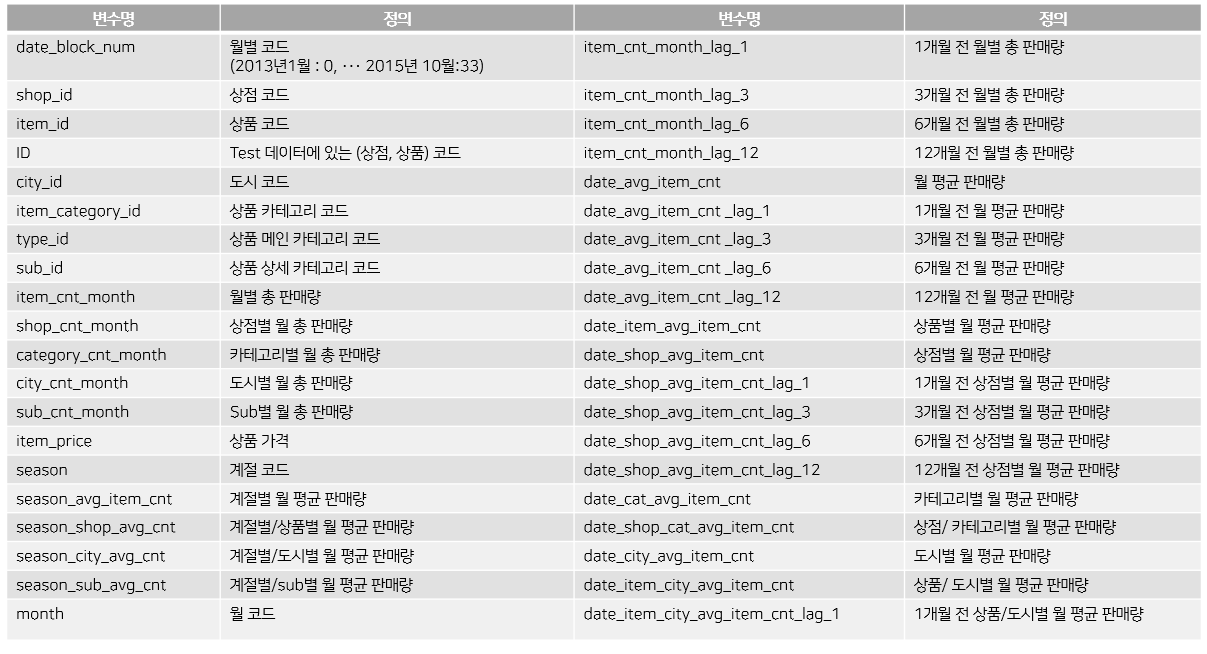